In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.integrate import simps
from scipy import signal
from PIL import Image

#import os, sys
#sys.path.append("/home/cczhu/GitHub/moon_craters")

import make_density_map as mdm

In [3]:
# Load stuff

imgloc = "test/lola_13724.png"
craterloc = "test/lola_13724.csv"

img = Image.open(imgloc).convert("L")
img = np.asanyarray(img)
craters = pd.read_csv(craterloc)
minpix = 3
craters.drop( np.where(craters["Diameter (pix)"] < minpix)[0], inplace=True )

<h2>Conv2D Method (from Kristen's ipynb)</h2>

In [3]:
# Copied from Kristen

def gkern(l=5, sig=1.):
    """
    Creates Gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))

    return kernel / np.sum(kernel)

def densmap_conv2d(img, craters, kernel_sig=4, kernel_extent=8, verbose=False):
    dmap_delta = np.zeros(img.shape)

    for i in range(craters.shape[0]):
        dmap_delta[int(craters["y"][i]), int(craters["x"][i])] +=1 # add one at crater location

    # keep kernel support odd number (for comparison with my function)
    kernel_support = int(kernel_extent*kernel_sig/2)*2 + 1
    kernel = gkern(kernel_support, kernel_sig)

    dmap = signal.convolve2d(dmap_delta, kernel, boundary='fill', mode='same')

    if verbose:
        print("Integration N = ", simps(simps(dmap, np.arange(dmap.shape[1])), np.arange(dmap.shape[0])), \
              " vs ground truth N = ", craters.shape[0])
    
    return dmap

In [4]:
dmap = densmap_conv2d(img, craters, verbose=True)

Integration N =  117.052996167  vs ground truth N =  118


In [5]:
%timeit -r 1 -n 100 dmap = densmap_conv2d(img, craters)

240 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


<h2>Adding Gaussians</h2>

In [6]:
dmap2 = mdm.make_density_map(craters, img.shape, k_sig=4.)
print("Integration N = ", simps(simps(dmap2, np.arange(dmap2.shape[1])), np.arange(dmap2.shape[0])), \
      " vs ground truth N = ", craters.shape[0])

Integration N =  117.052996167  vs ground truth N =  118


In [7]:
# Check if this result is the same as conv2:

print( np.isclose(dmap, dmap2, rtol=1e-05, atol=1e-08).sum()/ dmap.size )

1.0


1.0 means the two maps are identical (to 1e-5 relative error).

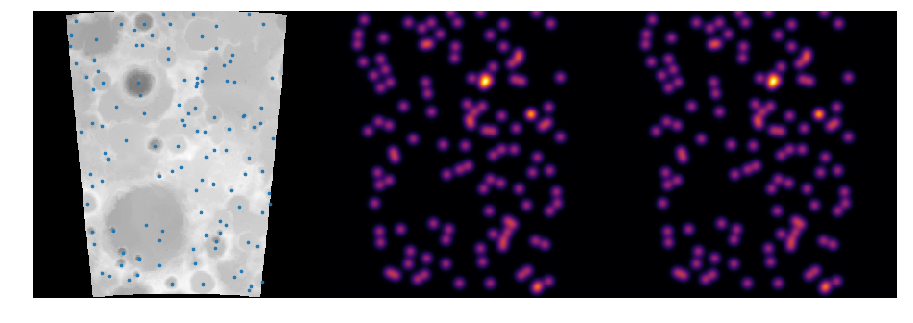

In [8]:
# Plot the two density maps

fig = plt.figure(figsize=[12, 4])

ax1 = fig.add_axes([0., 0., 1./3., 1.])
ax1.set_axis_off()
ax1.imshow(img, origin='upper', cmap="Greys_r")
ax1.scatter(craters["x"], craters["y"], s=7)
quiet = ax1.axis([0, img.shape[1], img.shape[0], 0])

ax2 = fig.add_axes([1./3., 0., 1./3., 1.])
ax2.set_axis_off()
ax2.imshow(dmap, origin='upper', cmap="inferno")
quiet = ax2.axis([0, img.shape[1], img.shape[0], 0])

ax2 = fig.add_axes([2./3., 0., 1./3., 1.])
ax2.set_axis_off()
ax2.imshow(dmap2, origin='upper', cmap="inferno")
quiet = ax2.axis([0, img.shape[1], img.shape[0], 0])

yup, identical

In [9]:
# Time trial
%timeit -r 1 -n 100 dmap2 = mdm.make_density_map(craters, img.shape, k_sig=4.)

18.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


So about 13 times faster.

<h2>Check Edge Cases</h2>

In [10]:
# Make fake image to see if my routine handles edge cases properly

img_x = 200
img_y = 200
img_dumm = np.zeros((img_x,img_y))

crat_x_list = np.array([100, 50, 2, 4, 167, 72, 198, 1])
crat_y_list = np.array([100, 50, 1, 122, 3, 199, 198, 199])
craters_dumm = pd.DataFrame([crat_x_list, crat_y_list]).T.rename(columns={0 : "x", 1 : "y"})

for i in range(len(crat_x_list)):
    img_dumm[crat_y_list[i],crat_x_list[i]] +=1 # add one at crater location
    
kernel_sig = 12
kernel_support = int(5 * kernel_sig/2)*2 + 1
kernel = gkern(kernel_support, kernel_sig)

img_conv = signal.convolve2d(img_dumm, kernel, boundary='fill', mode='same')
img_conv2 = mdm.make_density_map(craters_dumm, img_dumm.shape, k_sig=12., k_support=5)

print( np.isclose(img_conv, img_conv2, rtol=1e-05, atol=1e-06).sum()/ img_conv.size )

1.0


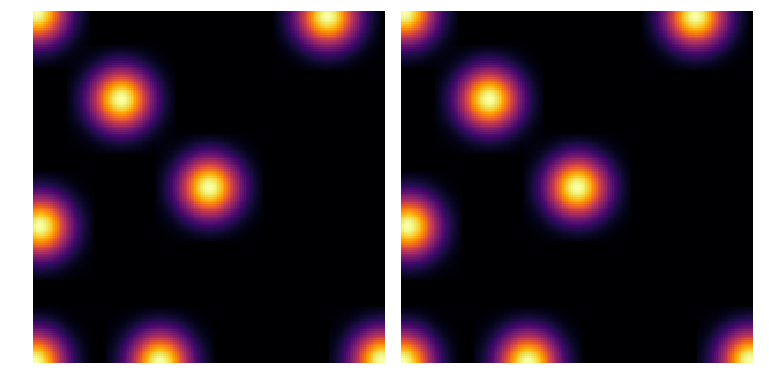

In [11]:
fig = plt.figure(figsize=[10, 5])

ax1 = fig.add_axes([0., 0., 0.49, 1.])
ax1.set_axis_off()
ax1.imshow(img_conv, origin='upper', cmap="inferno")
quiet = ax1.axis([0, img_conv.shape[1], img_conv.shape[0], 0])

ax2 = fig.add_axes([0.51, 0., 0.49, 1.])
ax2.set_axis_off()
ax2.imshow(img_conv2, origin='upper', cmap="inferno")
quiet = ax2.axis([0, img_conv.shape[1], img_conv.shape[0], 0])

<h2>Varying Kernel</h2>

In [12]:
dmap_ck = mdm.make_density_map(craters, img.shape, k_sig=4., k_support=8)
print("Contant kernel integration N = ", simps(simps(dmap_ck, np.arange(dmap_ck.shape[1])), np.arange(dmap_ck.shape[0])), \
      " vs ground truth N = ", craters.shape[0])

dmap_dk = mdm.make_density_map(craters, img.shape, kernel="knn", k_support=8, beta=0.1)
print("beta*<d_i> kernel integration N = ", simps(simps(dmap_dk, np.arange(dmap_dk.shape[1])), np.arange(dmap_dk.shape[0])), \
      " vs ground truth N = ", craters.shape[0])

def ctr_sigma(craters, gamma):
    return gamma*craters["Diameter (pix)"].as_matrix()

dmap_cust = mdm.make_density_map(craters, img.shape, kernel=ctr_sigma, k_support=8, kdict={"craters": craters, "gamma": 0.5})
print("Custom kernel integration N = ", simps(simps(dmap_cust, np.arange(dmap_cust.shape[1])), np.arange(dmap_cust.shape[0])), \
      " vs ground truth N = ", craters.shape[0])

Contant kernel integration N =  117.052996167  vs ground truth N =  118
beta*<d_i> kernel integration N =  117.031864591  vs ground truth N =  118
Custom kernel integration N =  116.595679316  vs ground truth N =  118


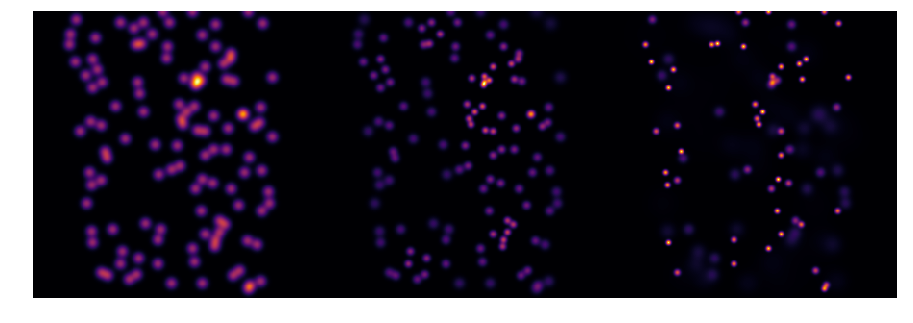

In [13]:
# Plot the two density maps

fig = plt.figure(figsize=[12, 4])

ax1 = fig.add_axes([0., 0., 1./3., 1.])
ax1.set_axis_off()
ax1.imshow(dmap_ck, origin='upper', cmap="inferno")
quiet = ax1.axis([0, img.shape[1], img.shape[0], 0])

ax2 = fig.add_axes([1./3., 0., 1./3., 1.])
ax2.set_axis_off()
ax2.imshow(dmap_dk, origin='upper', cmap="inferno")
quiet = ax2.axis([0, img.shape[1], img.shape[0], 0])

ax2 = fig.add_axes([2./3., 0., 1./3., 1.])
ax2.set_axis_off()
ax2.imshow(dmap_cust, origin='upper', cmap="inferno")
quiet = ax2.axis([0, img.shape[1], img.shape[0], 0])

<h2>Mask</h2>

In [46]:
mask = mdm.make_mask(craters, img.shape, binary=True)

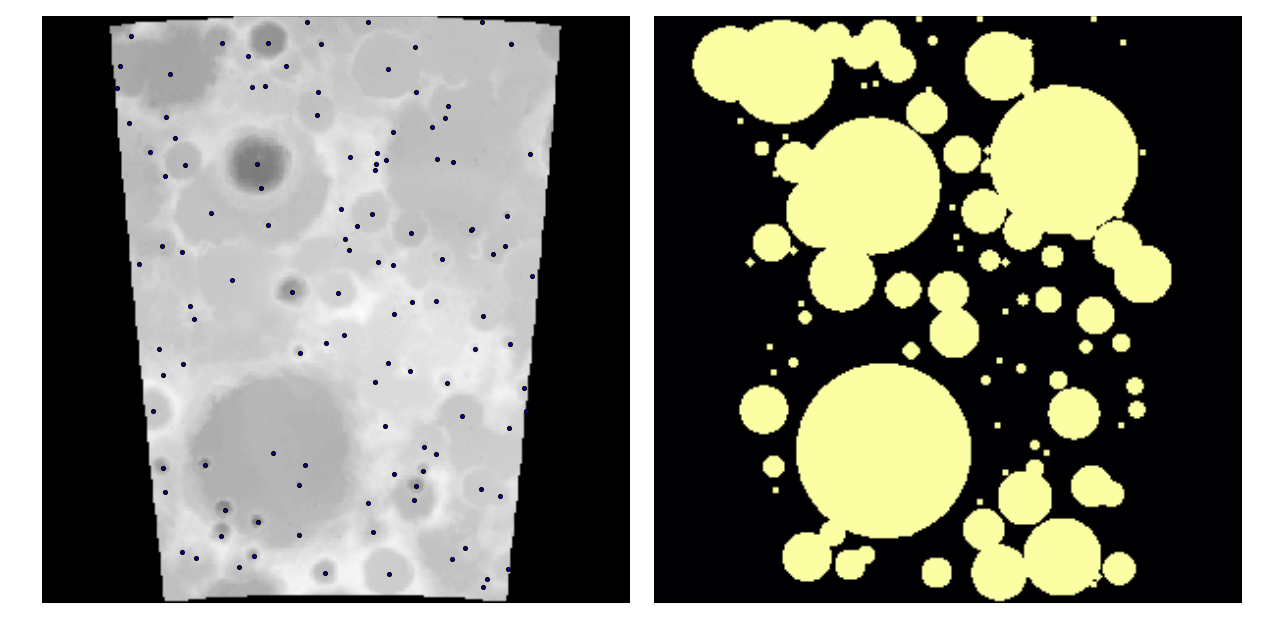

In [48]:
fig = plt.figure(figsize=[12, 6])

ax1 = fig.add_axes([0., 0., 0.49, 1.])
ax1.set_axis_off()
ax1.imshow(img, origin='upper', cmap="Greys_r")
ax1.scatter(craters["x"], craters["y"], s=7)
quiet = ax1.axis([0, img.shape[1], img.shape[0], 0])

ax2 = fig.add_axes([0.51, 0., 0.49, 1.])
ax2.set_axis_off()
ax2.imshow(mask, origin='upper', cmap="inferno")
quiet = ax2.axis([0, mask.shape[1], mask.shape[0], 0])

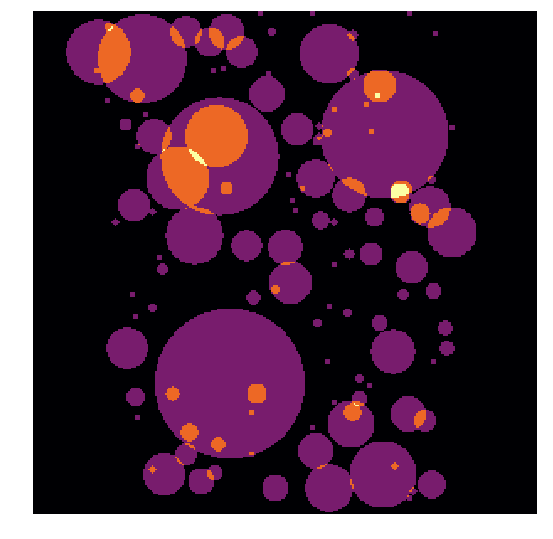

In [16]:
# If you want a multi-valued crater mask...

mask = mdm.make_mask(craters, img.shape, binary=False)

fig = plt.figure(figsize=[7, 7])
ax = fig.add_axes([0., 0., 1., 1.])
ax.set_axis_off()
ax.imshow(mask, origin='upper', cmap="inferno")
quiet = ax.axis([0, mask.shape[1], mask.shape[0], 0])

In [8]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline 

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.integrate import simps
from scipy import signal
from PIL import Image

#import os, sys
#sys.path.append("/home/cczhu/GitHub/moon_craters")

import make_density_map as mdm

def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return resized

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    print "number of %s files are: %d"%(data_type,len(files))
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl,img_width,img_height)
        X.append(img)
        X_id.append(fl)
        
        csv = pd.read_csv('%s.csv'%fl.split('.png')[0])
        csv.drop( np.where(csv["Diameter (pix)"] < minpix)[0], inplace=True )
        y.append(mdm.make_mask(csv, (img_width,img_height), binary=True))
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data, dtype=np.uint8)       #convert to numpy
    target = np.array(target, dtype=np.uint8)
    data = data.astype('float32')               #convert to float
    data = data / 255                           #normalize
    print('%s shape:'%data_type, data.shape)
    return data, target, id


In [9]:
train_data, train_target, train_id = read_and_normalize_data('training_set/', 300, 300, 0)

number of train files are: 20
('train shape:', (20, 300, 300, 3))


In [91]:
def custom_image_generator(data, target, batch_size=2):
    np.random.seed(0)
    while True:
        for i in range(0, len(data), batch_size):
            d, t = data[i:i+batch_size].copy(), target[i:i+batch_size].copy() #length batch_size
            lr, ud = np.where(np.random.randint(0,2,batch_size)==1)[0], np.where(np.random.randint(0,2,batch_size)==1)[0]
            for j in lr:
                d[j], t[j] = np.fliplr(d[j]), np.fliplr(t[j])   #horizontal flips
            for j in ud:
                d[j], t[j] = np.flipud(d[j]), np.flipud(t[j])   #vertical flips
            yield (d, t)

In [92]:
n_images = 10
images = []
for batch in custom_image_generator(train_data,train_target,len(train_data)):
    images.append(batch)
    break 

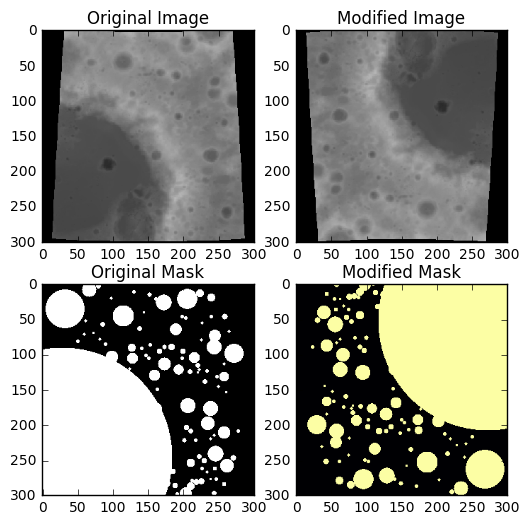

In [102]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[6, 6])
i=5

ax1.imshow(train_data[i], origin='upper', cmap="Greys_r")
ax1.set_title('Original Image')

ax2.imshow(images[0][0][i], origin='upper', cmap="inferno")
ax2.set_title('Modified Image')

ax3.imshow(train_target[i], origin='upper', cmap="Greys_r")
ax3.set_title('Original Mask')

ax4.imshow(images[0][1][i], origin='upper', cmap="inferno")
ax4.set_title('Modified Mask')